In [28]:
import os 
import numpy as np
import pandas as pd
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns

from data_provider.data_factory import data_provider
%reload_ext autoreload
%autoreload 2

In [10]:
lt_logs_df = pd.read_csv('./logs/calmip_logs.csv', index_col = 0)
from types import SimpleNamespace
usc_args = SimpleNamespace(**lt_logs_df.loc[471].to_dict())
usc_args.batch_size = 25

usc_args.input_features = 'A'
usc_args.use_offense = False
usc_args.seq_len = 24
usc_args.pred_len = 24
usc_args.features = 'MS'
usc_args.consider_only_offense = True

usc_args.root_path = "./dataset/USC/"
usc_args.checkpoints = "./checkpoints/"
usc_args.results_path = "./results/"

In [13]:
uscds_tr, uscdl_tr = data_provider(args= usc_args, flag = 'train')
uscds_tr.scale

train 62446


True

In [14]:
uscds_te, uscdl_te = data_provider(args= usc_args, flag = 'test')
uscds_te.scale

test 13382


True

In [27]:
print(uscds_tr.data_y.shape)
uscds_tr.data_y[:,-1,0]

(62446, 24, 1)


array([ 1.3646619,  1.284041 ,  1.2648414, ..., -1.5220808, -1.5651474,
       -1.5761852], dtype=float32)

In [26]:
print(uscds_te.data_y.shape)
uscds_te.data_y[:,-1,0]

(13382, 24, 1)


array([ 0.22422034,  0.2496033 ,  0.26992837, ..., -0.39535883,
       -0.42563042, -0.45257106], dtype=float32)

In [48]:
usc_args.use_action_progress

False

In [89]:
Y_tr_true = np.load('./dataset/USC/seq24_pred24_Y.npy')
print(Y_tr_true.shape)
print(uscds_tr.data_y.shape[0] + 2*uscds_te.data_y.shape[0] )
np.round(Y_tr_true[0,0,:],2)

(89210, 24, 63)
89210


array([ 1.  ,  0.16,  1.  , 21.04, 48.15,  1.39,  1.39, 22.1 , 47.86,
        3.65,  3.44, 22.64, 40.35,  3.74,  3.57, 22.81, 51.81,  1.8 ,
        1.76, 19.55, 38.29,  3.93,  3.92, 21.81, 54.32,  1.54,  1.21,
       15.63, 29.62,  2.66,  2.62, 22.6 , 52.54,  1.69,  1.48, 21.  ,
       49.44,  2.51,  1.91, 16.86, 49.73,  1.35, -1.27, 17.29, 67.25,
        0.72,  0.36, 24.46, 51.82,  1.23,  0.7 , 20.02, 35.38,  3.11,
       -0.9 , 10.07, 17.27,  1.6 ,  1.36, 11.98, 40.06,  1.17,  0.13],
      dtype=float32)

In [90]:
angle_mask = [(i+2)%4 == 0 and i >2 for i in range(Y_tr_true.shape[2])]
Y_tr_true[0,-1,angle_mask]

array([-0.38755843,  3.178949  ,  3.9451783 , -0.01748937,  4.793165  ,
        2.7150667 ,  2.966743  ,  0.        ,  0.8675097 ,  0.12131345,
        0.8320691 , -0.06128666, -0.6361876 ,  0.41080967,  0.18339096],
      dtype=float32)

In [65]:
df = pd.read_csv('../Collective_behavior/preproc_data/USC/all_games_positions.csv',index_col = 0)
df

,frame,player_id,x,y,action,half,offense,player,v_x,v_y,v,uv_x,uv_y,goal_angle,target,act_progression,game_id,action_id
0,2023-08-25 19:31:27.400,JEAN THOMAS,22.233002,55.553402,1,1,True,4,NaN,NaN,NaN,NaN,NaN,NaN,14.170314,0.000000,2324_02,1
1,2023-08-25 19:31:27.400,JACK WHETTON,22.483604,30.255229,1,1,True,5,NaN,NaN,NaN,NaN,NaN,NaN,14.170314,0.000000,2324_02,1
2,2023-08-25 19:31:27.400,GUILLAUME TARTAS,23.177224,53.527926,1,1,True,1,NaN,NaN,NaN,NaN,NaN,NaN,14.170314,0.000000,2324_02,1
3,2023-08-25 19:31:27.400,DORIAN LABORDE,27.876374,51.659946,1,1,True,12,NaN,NaN,NaN,NaN,NaN,NaN,14.170314,0.000000,2324_02,1
4,2023-08-25 19:31:27.400,FABIEN PERRIN,25.649343,34.601532,1,1,True,13,NaN,NaN,NaN,NaN,NaN,NaN,14.170314,0.000000,2324_02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188920,2025-03-07 20:57:24.100,BRETT HERRON,43.731861,37.777256,102,2,False,10,-0.403193,-0.092362,0.413636,-0.974751,-0.223292,-167.097511,58.473546,-0.754026,2425_23,41102
188921,2025-03-07 20:57:24.100,UGO PACOME,40.570186,18.138857,102,2,False,9,-0.895585,-0.447215,1.001037,-0.894658,-0.446752,-153.464500,58.473546,-0.754026,2425_23,41102
188922,2025-03-07 20:57:24.100,VINCENT PINTO,58.047428,29.359716,102,2,False,14,-1.398516,-0.497747,1.484453,-0.942109,-0.335307,-160.408795,58.473546,-0.754026,2425_23,41102
188923,2025-03-07 20:57:24.100,LOUIS DESCOUX,55.923958,28.504784,102,2,False,5,2.069783,-0.930800,2.269447,0.912021,-0.410144,-24.213872,58.473546,-0.754026,2425_23,41102


(array([671693., 668418., 847268., 635131., 858987., 795167., 670873.,
        866017., 654612., 659169.]),
 array([-1.79999803e+02, -1.43999829e+02, -1.07999856e+02, -7.19998823e+01,
        -3.59999089e+01,  6.45568576e-05,  3.60000380e+01,  7.20000114e+01,
         1.07999985e+02,  1.43999958e+02,  1.79999932e+02]),
 <BarContainer object of 10 artists>)

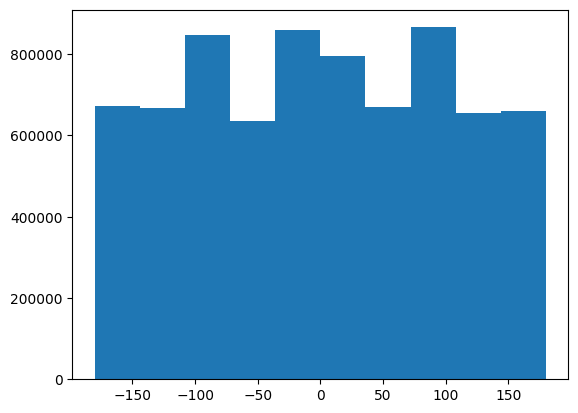

In [66]:
plt.hist(df['goal_angle'])

(80037, 32, 63) (80037, 32, 63)


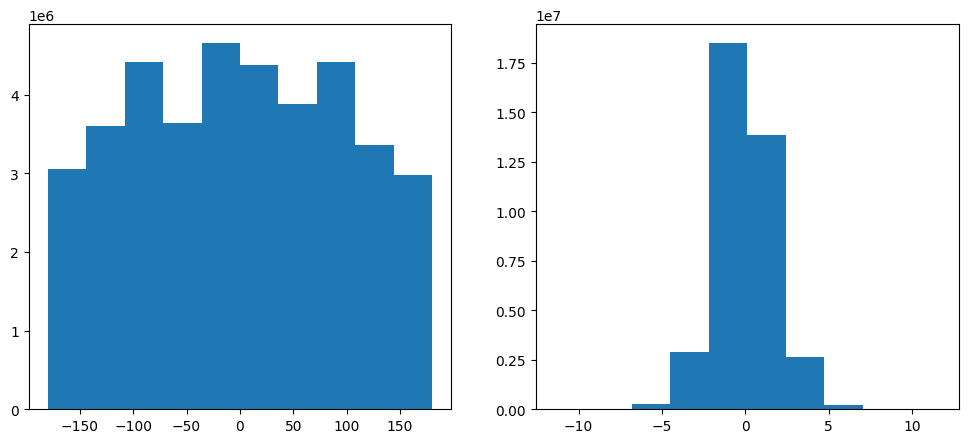

In [103]:
th = 32
Xs = np.load(f'./dataset/USC/seq{th}_pred{th}_X.npy')
Ys = np.load(f'./dataset/USC/seq{th}_pred{th}_Y.npy')
print(Xs.shape, Ys.shape)
angle_mask = [(i+2)%4 == 0 and i >2 for i in range(Y_tr_true.shape[2])]

fig, axs = plt.subplots(1,2,figsize = (12,5));
axs[0].hist(Xs[:,:,angle_mask].reshape(-1));
axs[1].hist(Ys[:,:,angle_mask].reshape(-1));


(array([1876529., 2105480., 2538330., 2108620., 2689501., 2511907.,
        2236259., 2575857., 1985295., 1852782.]),
 array([-9.99998927e-01, -7.99999058e-01, -5.99999189e-01, -3.99999350e-01,
        -1.99999496e-01,  3.57627869e-07,  2.00000212e-01,  4.00000066e-01,
         5.99999905e-01,  7.99999774e-01,  9.99999642e-01]),
 <BarContainer object of 10 artists>)

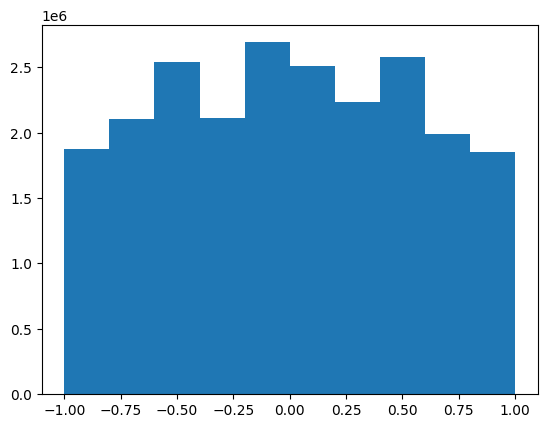

In [76]:
angle_mask_2 = [(i+4)%4 == 0 and i >2 for i in range(uscds_tr.data_x.shape[2])]

plt.hist(uscds_tr.data_x[:,:,angle_mask_2].reshape(-1))

In [69]:
Y_tr_true[:,:,angle_mask].reshape(-1).min(), Y_tr_true[:,:,angle_mask].reshape(-1).max()

(-11.404583, 11.782818)

(array([2.5900000e+02, 5.1950000e+03, 2.4364500e+05, 2.5099120e+06,
        1.6288870e+07, 1.0832669e+07, 2.0867010e+06, 1.4679800e+05,
        1.4860000e+03, 6.5000000e+01]),
 array([-11.40458298,  -9.08584309,  -6.76710272,  -4.44836283,
         -2.1296227 ,   0.18911743,   2.50785756,   4.82659769,
          7.14533758,   9.46407795,  11.78281784]),
 <BarContainer object of 10 artists>)

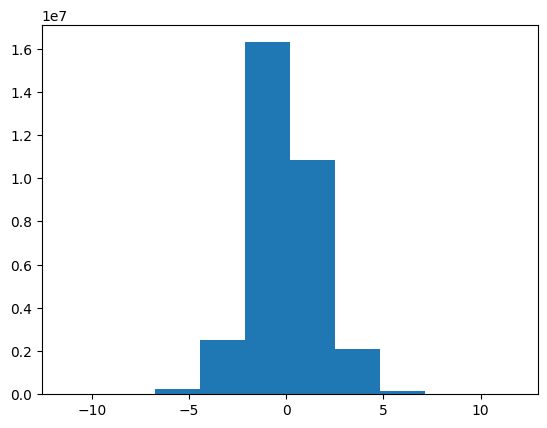

In [62]:
plt.hist(Y_tr_true[:,:,angle_mask].reshape(-1))

In [55]:
print(Y_tr_true[:uscds_tr.__len__(), :, 1].reshape(-1).mean())
uscds_tr.scaler['mean'][0], uscds_te.scaler['mean'][0]

0.37961665


(-0.31447268, -0.31447268)

In [39]:
x, y_true , _, _= next(iter(uscdl_te))
y_true = y_true [:,-uscds_te.args.pred_len:,:]

y_true_shape = y_true.shape
test_it = uscds_te.inverse_transform(y_true.reshape(y_true_shape[0] * y_true_shape[1], -1)).reshape(y_true_shape)

600


In [84]:
y_true[:,:,0:].shape

torch.Size([25, 24, 1])

In [41]:
test_it.shape

torch.Size([25, 24, 1])

In [51]:
len(uscds_tr.scaler['mean'])

61

In [34]:
uscds_te.scaler

{'mean': [-0.31447268,
  50,
  35,
  1.6205294,
  0,
  50,
  35,
  1.6523768,
  0,
  50,
  35,
  1.6473053,
  0,
  50,
  35,
  1.7604458,
  0,
  50,
  35,
  1.7135544,
  0,
  50,
  35,
  1.6821164,
  0,
  50,
  35,
  1.563787,
  0,
  50,
  35,
  1.6497974,
  0,
  50,
  35,
  2.2787786,
  0,
  50,
  35,
  1.8954127,
  0,
  50,
  35,
  1.7134509,
  0,
  50,
  35,
  1.8009133,
  0,
  50,
  35,
  1.8541431,
  0,
  50,
  35,
  1.7068683,
  0,
  50,
  35,
  1.8884925,
  0],
 'scale': [1.9331441,
  50,
  50,
  1.2340605,
  180,
  50,
  50,
  1.306971,
  180,
  50,
  50,
  1.2039827,
  180,
  50,
  50,
  1.3017693,
  180,
  50,
  50,
  1.2484413,
  180,
  50,
  50,
  1.3771782,
  180,
  50,
  50,
  1.2901967,
  180,
  50,
  50,
  1.3225322,
  180,
  50,
  50,
  1.5816572,
  180,
  50,
  50,
  1.3772091,
  180,
  50,
  50,
  1.4911642,
  180,
  50,
  50,
  1.3764751,
  180,
  50,
  50,
  1.4314095,
  180,
  50,
  50,
  1.4299009,
  180,
  50,
  50,
  1.5071014,
  180],
 'offset_x': 0,
 'offset_